In [1]:
import numpy as np
from numpy.ma import masked_values as maval
import gsw
import xarray as xr
import pandas as pd
import os.path as op
from datetime import datetime, timedelta
from scipy.interpolate import PchipInterpolator as pchip
from scipy.signal import medfilt
import dask.array as dsar
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import cm
import matplotlib.colors as clr
import matplotlib.ticker as tick
import matplotlib.path as mpath
import matplotlib.pyplot as plt
%matplotlib inline

In [178]:
import cmocean as cmocean

Float numbers for SOCCOM floats dropped off I06S
12878	5906033	5906033	325020190403	I06S	14	1	20190418	1503	-65.499420	30.000760	20190419	0001	-65.5033	29.9567	Apex	IONpF
12882	5906032	5906032	325020190403	I06S	uwDrop	-	-	-	-	-	20190506	0153	-44.9583	29.0883	Apex	IONpF
12885	5906031	5906031	325020190403	I06S	33	1	20190424	1853	-55.999800	30.002800	20190425	0519	-55.8717	29.9400	Apex	IONpF
12888	5906030	5906030	325020190403	I06S	42	1	20190430	0816	-51.499940	30.001580	20190430	1854	-51.3550	30.2083	Apex	IONpF
12892	5906034	5906034	325020190403	I06S	19	1	20190419	2333	-63.000360	29.999700	20190420	0950	-63.0267	29.9967	Apex	IONpF


Identified from SOCCOM float viz: https://www.mbari.org/science/upper-ocean-systems/chemical-sensor-group/soccom-float-visualization/
12880 (dropped off ANDREXII), 12882, 12885, 12888, 9657(floated into the region)

The others dopped during the same cruise are either too far south under the ice, or too far north. 

In [18]:
SOCCOM_flt_ids = [12880, 12882, 12885, 12888, 9657]

In [17]:
HRdir = '/Users/dhruvbalwada/work_root/sogos/data/raw/SOCCOM/manual_download/SOCCOM_HRQC_LIAR_netcdf_20191006/'
LRdir = '/Users/dhruvbalwada/work_root/sogos/data/raw/SOCCOM/manual_download/SOCCOM_LRQC_LIAR_netcdf_20191006/'

In [26]:
float_dic_HR = {}
float_dic_LR = {}

for i in SOCCOM_flt_ids: 
    float_dic_HR[i] = xr.open_dataset(HRdir + str(i) + 'SOOCN_HRQC.nc')
    float_dic_LR[i] = xr.open_dataset(LRdir + str(i) + 'SOOCNQC.nc')

(-65, -40)

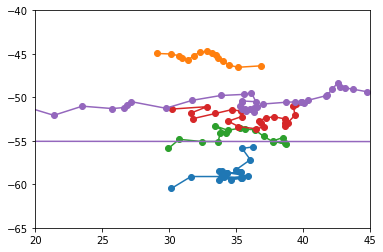

In [72]:
for i in [12880, 12882, 12885, 12888, 9657]:
    plt.plot(float_dic_HR[i].Lon, float_dic_HR[i].Lat, Marker='o')
    #plt.text(float_dic_HR[i].Lon[0], float_dic_HR[i].Lat[0], i)
    
plt.xlim([20, 45])
plt.ylim([-65, -40])

/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


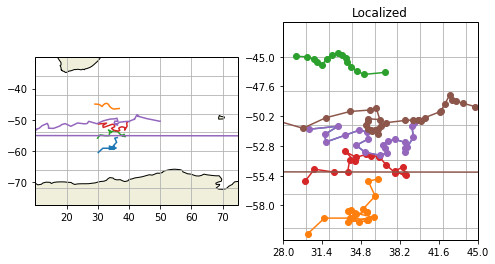

In [79]:
plt.figure(figsize=(8,4))
ax = plt.subplot(121, projection = ccrs.PlateCarree())  # create a set of axes with Mercator projection
ax.set_xticks([20, 30,40, 50, 60, 70], crs=ccrs.PlateCarree())
ax.set_yticks([-70, -60, -50, -40], crs=ccrs.PlateCarree())
ax.set_extent([10, 75, -75, -30])
ax.add_feature(cfeature.COASTLINE)  
ax.add_feature(cfeature.LAND)# plot some data on them
for i in [12880, 12882, 12885, 12888, 9657]:
    ax.plot(float_dic_HR[i].Lon.values, float_dic_HR[i].Lat.values, '-',
               rasterized=True)
ax.gridlines()
ax.set_title("")                        # label it


ax = plt.subplot(122, projection = ccrs.PlateCarree())  # create a set of axes with Mercator projection
ax.set_xticks(np.linspace(28,45,6), crs=ccrs.PlateCarree())
ax.set_yticks(np.linspace(-58.,-45,6) , crs=ccrs.PlateCarree())
ax.set_extent([28, 45, -61, -42])
ax.add_feature(cfeature.COASTLINE)                 # plot some data on them
ax.plot(ds.Lon.values, ds.Lat.values)
#ax.scatter(ds_HR.Lon.values, ds_HR.Lat.values,
#           s=25., c=ds_HR.groupby('JULD').mean().JULD.values,
#               rasterized=True)
for i in [12880, 12882, 12885, 12888, 9657]:
    ax.plot(float_dic_HR[i].Lon.values, float_dic_HR[i].Lat.values, 'o-',
               rasterized=True)
ax.gridlines()
ax.set_title("Localized")                            # label it

plt.tight_layout()

In [106]:
np.datetime64('2019-01-01')

numpy.datetime64('2019-01-01')

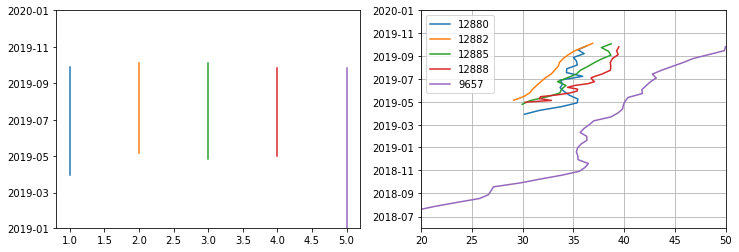

In [112]:
plt.figure(figsize=(12,4))

plt.subplot(121)
n=1
for i in float_dic_HR.keys():
    plt.plot(n*np.ones(len(float_dic_HR[i].JULD)),
             float_dic_HR[i].JULD)
    n+=1
plt.ylim([np.datetime64('2019-01-01'), np.datetime64('2020-01-01')])

plt.subplot(122)

for i in float_dic_HR.keys():
    plt.plot(float_dic_HR[i].Lon,
             float_dic_HR[i].JULD, label=i)
    n+=1
plt.ylim([np.datetime64('2018-06-01'), np.datetime64('2020-01-01')])
plt.xlim([20, 50])
plt.grid()
plt.legend()

In [102]:
float_dic_HR[i].JULD.where(float_dic_HR[i].Lon>10)

<xarray.DataArray 'JULD' (N_PROF: 132)>
array(['2016-01-08T08:56:00.000004352', '2016-01-18T17:45:59.999999744',
       '2016-01-29T01:18:00.000002560', '2016-02-08T08:21:59.999995136',
       '2016-02-18T16:04:59.999998976', '2016-02-28T23:21:59.999995136',
       '2016-03-10T06:53:00.000001536', '2016-03-20T13:54:00.000004608',
       '2016-03-30T21:55:00.000004352', '2016-04-10T08:31:00.000003072',
       '2016-04-20T15:55:00.000004352', '2016-05-01T00:06:59.999995136',
       '2016-05-11T09:44:00.000003584', '2016-05-21T18:25:59.999997440',
       '2016-06-01T04:07:59.999998208', '2016-06-11T14:56:00.000004352',
       '2016-06-21T21:56:59.999997440', '2016-07-02T06:02:59.999999232',
       '2016-07-12T14:11:00.000004352', '2016-07-22T20:39:00.000004608',
       '2016-08-02T05:06:59.999998464', '2016-08-12T14:46:59.999996160',
       '2016-08-22T22:30:00.000000000', '2016-09-02T04:27:00.000000768',
       '2016-09-12T10:29:00.000003584', '2016-09-22T21:44:00.000003584',
       '201

### 12888 
This is the float that was released with the gliders

In [133]:
ds_flt = float_dic_HR[12888]
ds_flt_LR = float_dic_LR[12888]

In [128]:
ds_flt

<xarray.Dataset>
Dimensions:              (NPARAMETER: 46, N_LEVELS: 558, N_PROF: 23)
Dimensions without coordinates: NPARAMETER, N_LEVELS, N_PROF
Data variables:
    Cruise               |S11 ...
    Station              (N_PROF) int32 ...
    Lon                  (N_PROF) float64 30.23 32.83 31.63 ... 39.4 39.25 39.47
    Lat                  (N_PROF) float64 -51.34 -51.07 -51.8 ... -51.04 -50.76
    Lat_QF               (N_PROF) |S1 ...
    Lat_QFA              (N_PROF) float64 ...
    Pressure             (N_PROF, N_LEVELS) float64 1.799e+03 1.699e+03 ... nan
    Pressure_QF          (N_PROF, N_LEVELS) |S1 ...
    Pressure_QFA         (N_PROF, N_LEVELS) float64 ...
    Temperature          (N_PROF, N_LEVELS) float64 ...
    Temperature_QF       (N_PROF, N_LEVELS) |S1 ...
    Temperature_QFA      (N_PROF, N_LEVELS) float64 ...
    Salinity             (N_PROF, N_LEVELS) float64 ...
    Salinity_QF          (N_PROF, N_LEVELS) |S1 ...
    Salinity_QFA         (N_PROF, N_LEVELS) float6

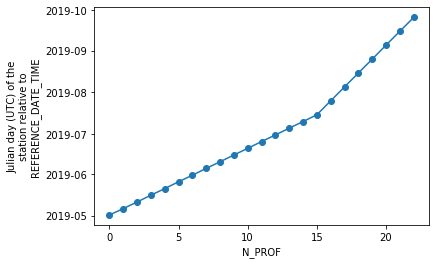

In [88]:
ds_flt.JULD.plot(Marker='o')
# the faster sampling is visible for the first 15 profiles. 

In [140]:
ds_flt.Pressure.fillna(value=-999)

<xarray.DataArray 'Pressure' (N_PROF: 23, N_LEVELS: 558)>
array([[1799.07, 1698.72, 1599.01, ..., -999.  , -999.  , -999.  ],
       [1798.96, 1699.  , 1599.85, ..., -999.  , -999.  , -999.  ],
       [ 977.9 ,  976.  ,  974.  , ..., -999.  , -999.  , -999.  ],
       ...,
       [1799.16, 1699.94, 1599.94, ..., -999.  , -999.  , -999.  ],
       [1798.8 , 1699.44, 1599.59, ..., -999.  , -999.  , -999.  ],
       [1798.84, 1699.03, 1599.32, ...,    5.9 ,    4.3 , -999.  ]])
Dimensions without coordinates: N_PROF, N_LEVELS
Attributes:
    units:    dbar

In [163]:
ds_flt.pressure

AttributeError: 'Dataset' object has no attribute 'pressure'

In [160]:
Numgrid = np.tile(ds_flt.N_PROF, (558,1))
Numgrid.shape

(558, 23)

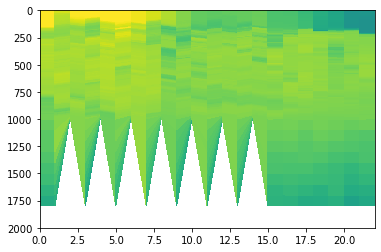

In [172]:
plt.pcolormesh(Numgrid.T, ds_flt.Pressure.fillna(value=-999), 
               ds_flt.Temperature, vmin=-1, vmax=3, shading='flat')
plt.ylim([0, 2000])
plt.gca().invert_yaxis()

In [173]:
plt.scatter?

Signature:
plt.scatter(
    x,
    y,
    s=None,
    c=None,
    marker=None,
    cmap=None,
    norm=None,
    vmin=None,
    vmax=None,
    alpha=None,
    linewidths=None,
    verts=None,
    edgecolors=None,
    *,
    plotnonfinite=False,
    data=None,
    **kwargs,
)
Docstring:
A scatter plot of *y* vs *x* with varying marker size and/or color.

Parameters
----------
x, y : array_like, shape (n, )
    The data positions.

s : scalar or array_like, shape (n, ), optional
    The marker size in points**2.
    Default is ``rcParams['lines.markersize'] ** 2``.

c : color, sequence, or sequence of color, optional
    The marker color. Possible values:

    - A single color format string.
    - A sequence of color specifications of length n.
    - A sequence of n numbers to be mapped to colors using *cmap* and
      *norm*.
    - A 2-D array in which the rows are RGB or RGBA.

    Note that *c* should not be a single numeric RGB or RGBA sequence
    because that is indistinguishable f

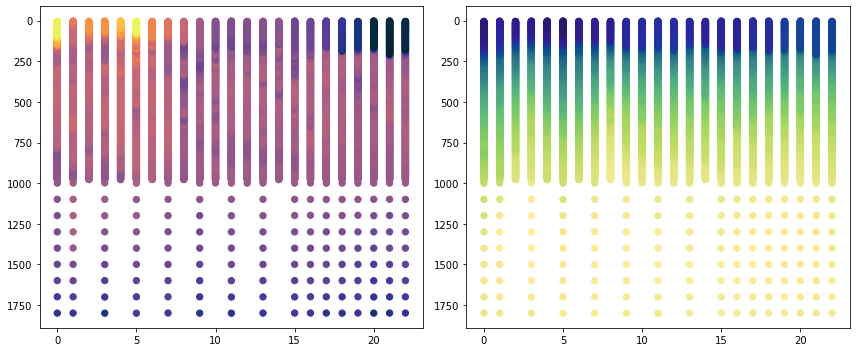

In [187]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.scatter(Numgrid.T, ds_flt.Pressure, s=40,
            c=ds_flt.Temperature, cmap=cmocean.cm.thermal)
plt.gca().invert_yaxis()

plt.subplot(122)
plt.scatter(Numgrid.T, ds_flt.Pressure, s=40,
            c=ds_flt.Salinity, cmap=cmocean.cm.haline)
plt.gca().invert_yaxis()

plt.tight_layout()

In [145]:
help(plt.pcolormesh)

Help on function pcolormesh in module matplotlib.pyplot:

pcolormesh(*args, alpha=None, norm=None, cmap=None, vmin=None, vmax=None, shading='flat', antialiased=False, data=None, **kwargs)
    Create a pseudocolor plot with a non-regular rectangular grid.
    
    Call signature::
    
        pcolor([X, Y,] C, **kwargs)
    
    *X* and *Y* can be used to specify the corners of the quadrilaterals.
    
    .. note::
    
       ``pcolormesh()`` is similar to :func:`~Axes.pcolor`. It's much
       faster and preferred in most cases. For a detailed discussion on
       the differences see
       :ref:`Differences between pcolor() and pcolormesh()
       <differences-pcolor-pcolormesh>`.
    
    Parameters
    ----------
    C : array_like
        A scalar 2-D array. The values will be color-mapped.
    
    X, Y : array_like, optional
        The coordinates of the quadrilateral corners. The quadrilateral
        for ``C[i,j]`` has corners at::
    
            (X[i+1, j], Y[i+1, j])   

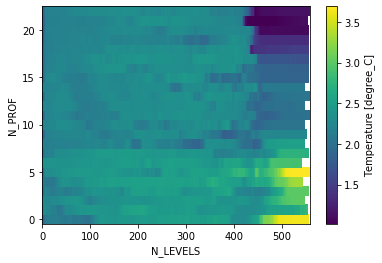

In [114]:
ds_flt.Temperature.plot()

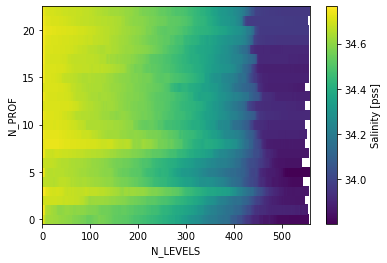

In [115]:
ds_flt.Salinity.plot()

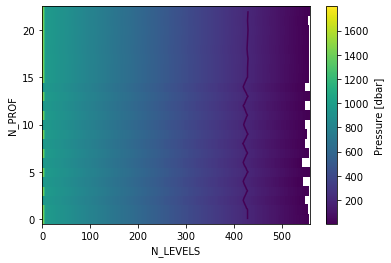

In [118]:
ds_flt.Pressure.plot()
ds_flt.Pressure.plot.contour(levels=[200])